In [1]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

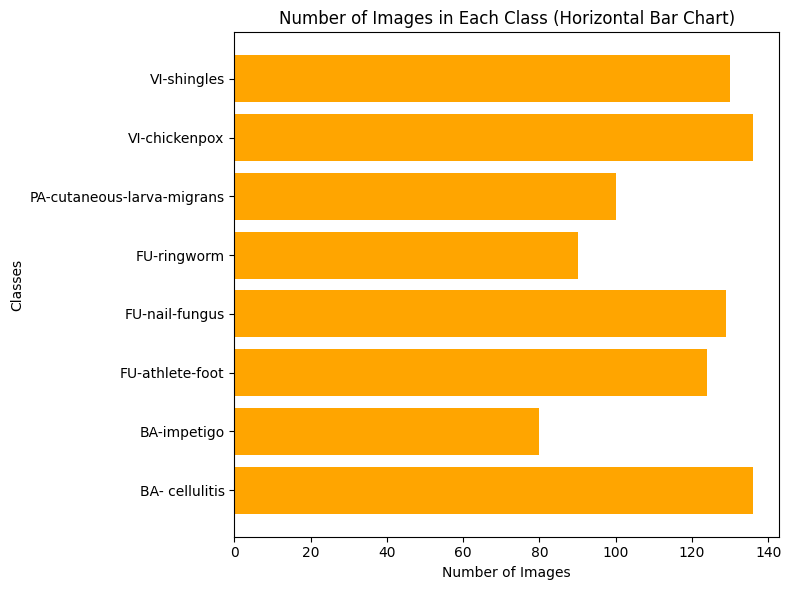

In [2]:
import os
import matplotlib.pyplot as plt

ROOT_DIR_AUG =r"skin-disease-datasaet" ############################ Change here
number_of_images = {}

for dir in os.listdir(ROOT_DIR_AUG):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR_AUG, dir)))

# Convert the dictionary items to lists
classes = list(number_of_images.keys())
counts = list(number_of_images.values())

# Plotting the horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(classes, counts, color='orange')
plt.xlabel('Number of Images')
plt.ylabel('Classes')
plt.title('Number of Images in Each Class (Horizontal Bar Chart)')
plt.tight_layout()

# Show the plot
plt.show()

In [3]:
train_data = []
val_data = []

for folder in os.listdir(ROOT_DIR_AUG):
    folder_path = os.path.join(ROOT_DIR_AUG, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))

    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))

    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

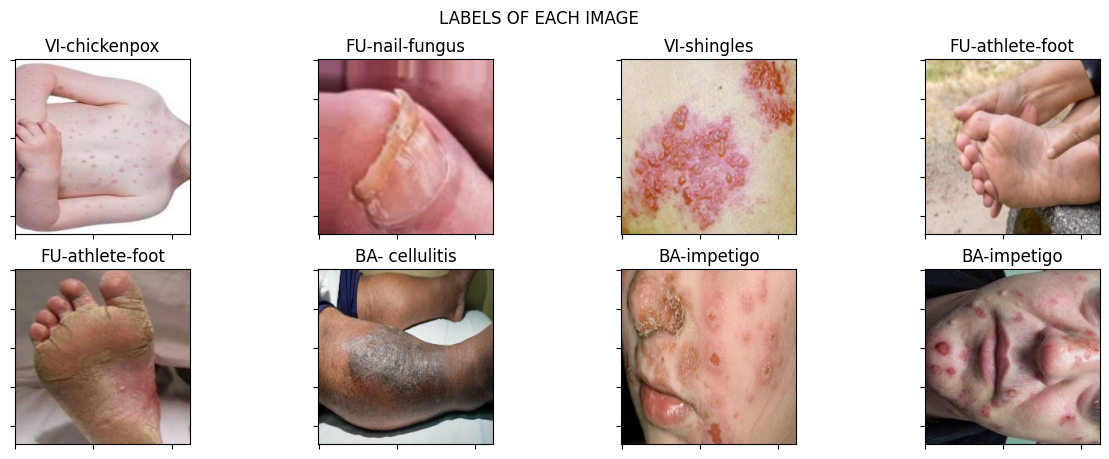

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(15, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (img, label), ax in zip(random.sample(train_data, 8), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(False)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Assuming train_data and val_data are your training and validation data respectively
# train_data = [(preprocess_input(input), label) for input, label in train_data]
# val_data = [(preprocess_input(input), label) for input, label in val_data]

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

# Calculate the number of unique classes in the training set
num_classes = len(np.unique(y_train))

# Convert labels to one-hot encoded vectors using to_categorical
y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=num_classes)


In [6]:
le.classes_

array(['BA- cellulitis', 'BA-impetigo', 'FU-athlete-foot',
       'FU-nail-fungus', 'FU-ringworm', 'PA-cutaneous-larva-migrans',
       'VI-chickenpox', 'VI-shingles'], dtype='<U26')

In [7]:
test_path = r"test_set" ############################################### Change Here
test_data = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224, 224))
        test_data.append((img, folder))


In [8]:
# Assuming you have a separate test dataset
X_test, y_test = zip(*test_data)

# Preprocess X_test similar to how you preprocessed X_train and X_val
X_test = preprocess_input(np.array(X_test))

# Use LabelEncoder to encode labels in y_test if needed (assuming le is already fitted)
y_test_encoded = le.transform(y_test)

# Assuming num_classes is defined as the number of unique classes in your dataset
y_test_one_hot = to_categorical(y_test_encoded, num_classes)


# ***Model-ResNet101***

In [9]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load ResNet101 model without the top (fully connected) layers
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
base_model.trainable = False

# Add custom top layers for your specific task
num_classes = 8
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model_5 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_5.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50
BATCH_SIZE = 32


#EARLY STOPPING & MODEL CHECKPOINTS
from keras.callbacks import ModelCheckpoint,EarlyStopping

#EARLY STOPPING
es = EarlyStopping(monitor = "val_accuracy",min_delta = 0.01,patience = 10,verbose = 1,mode = 'auto')

#MODEL CHECKPOINTS
mc = ModelCheckpoint(monitor = "val_accuracy",filepath =r"bestmodel_5.h5",verbose = 1,save_best_only = True,mode = 'auto')

cd_5 = [es,mc]



history_5 = model_5.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=BATCH_SIZE,callbacks=cd_5)

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 1.0486 - accuracy: 0.7263
Epoch 1: val_accuracy improved from -inf to 0.87166, saving model to bestmodel_5.h5
24/24 [==============================] - 12s 215ms/step - loss: 1.0486 - accuracy: 0.7263 - val_loss: 0.4401 - val_accuracy: 0.8717
Epoch 2/50
23/24 [===========================>..] - ETA: 0s - loss: 0.0879 - accuracy: 0.9715
Epoch 2: val_accuracy improved from 0.87166 to 0.89840, saving model to bestmodel_5.h5
24/24 [==============================] - 3s 120ms/step - loss: 0.0887 - accuracy: 0.9715 - val_loss: 0.2692 - val_accuracy: 0.8984
Epoch 3/50
23/24 [===========================>..] - ETA: 0s - loss: 0.0633 - accuracy: 0.9810
Epoch 3: val_accuracy improved from 0.89840 to 0.93583, saving model to bestmodel_5.h5
24/24 [==============================] - 3s 116ms/step - loss: 0.0631 - accuracy: 0.9810 - val_loss: 0.2497 - val_accuracy: 0.9358
Epoch 4/50
23/24 [===========================>..] - ETA: 0s - loss

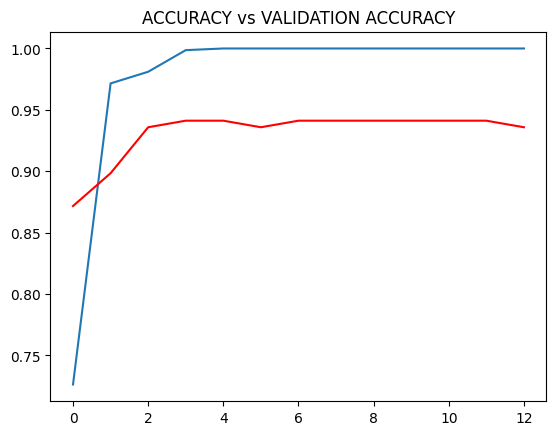

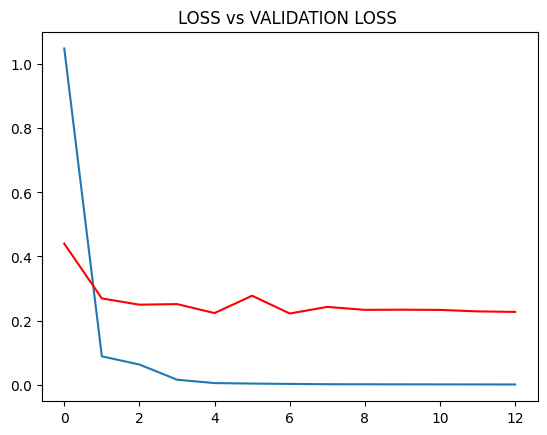

In [10]:
#GRAPHICAL INTERPRETATION
h5 = history_5.history
h5.keys()

import matplotlib.pyplot as plt
plt.plot(h5['accuracy'])
plt.plot(h5['val_accuracy'],c='red')
plt.title("ACCURACY vs VALIDATION ACCURACY")
plt.show()

import matplotlib.pyplot as plt
plt.plot(h5['loss'])
plt.plot(h5['val_loss'],c='red')
plt.title("LOSS vs VALIDATION LOSS ")
plt.show()


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 34ms/step


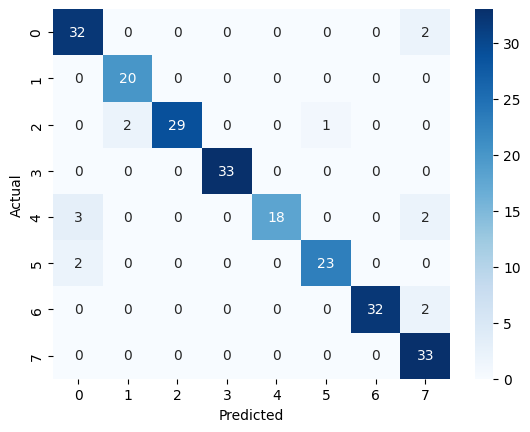

8/8 [==============================] - 1s 102ms/step
Accuracy: 0.9402
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        34
           1       0.91      1.00      0.95        20
           2       1.00      0.91      0.95        32
           3       1.00      1.00      1.00        33
           4       1.00      0.78      0.88        23
           5       0.96      0.92      0.94        25
           6       1.00      0.94      0.97        34
           7       0.85      1.00      0.92        33

    accuracy                           0.94       234
   macro avg       0.95      0.94      0.94       234
weighted avg       0.95      0.94      0.94       234



In [11]:
from tensorflow.keras.models import load_model
model_res101 = load_model(r"bestmodel_5.h5")


real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img]))  # Add an extra dimension for batching

        predictions = model_res101.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(real_label, predicted_class)
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

from sklearn.metrics import classification_report, accuracy_score


# Assuming you have predictions from your model on X_test
y_pred = model_res101.predict(X_test)

# Decode one-hot encoded labels back to their original form if needed
y_pred_decoded = np.argmax(y_pred, axis=1)
y_test_decoded = np.argmax(y_test_one_hot, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Accuracy: {accuracy:.4f}")

# Compute precision, recall, and F1-score
report = classification_report(y_test_decoded, y_pred_decoded)
print("Classification Report:")
print(report)


# ***MOdel VGG16***

In [12]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

num_classes = 8

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_2 = Model(inputs=base_model.input, outputs=predictions)
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50
BATCH_SIZE = 32


# Compile the model



#EARLY STOPPING & MODEL CHECKPOINTS
from keras.callbacks import ModelCheckpoint,EarlyStopping

#EARLY STOPPING
es = EarlyStopping(monitor = "val_accuracy",min_delta = 0.01,patience = 10,verbose = 1,mode = 'auto')

#MODEL CHECKPOINTS
mc = ModelCheckpoint(monitor = "val_accuracy",filepath =r"bestmodel_2.h5",verbose = 1,save_best_only = True,mode = 'auto')

cd_2 = [es,mc]



history_2 = model_2.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=BATCH_SIZE,callbacks=cd_2)

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 1.7773 - accuracy: 0.6260
Epoch 1: val_accuracy improved from -inf to 0.81818, saving model to bestmodel_2.h5
24/24 [==============================] - 8s 216ms/step - loss: 1.7773 - accuracy: 0.6260 - val_loss: 0.5685 - val_accuracy: 0.8182
Epoch 2/50
23/24 [===========================>..] - ETA: 0s - loss: 0.1475 - accuracy: 0.9538
Epoch 2: val_accuracy improved from 0.81818 to 0.91979, saving model to bestmodel_2.h5
24/24 [==============================] - 2s 88ms/step - loss: 0.1472 - accuracy: 0.9539 - val_loss: 0.3382 - val_accuracy: 0.9198
Epoch 3/50
23/24 [===========================>..] - ETA: 0s - loss: 0.0376 - accuracy: 0.9973
Epoch 3: val_accuracy improved from 0.91979 to 0.94118, saving model to bestmodel_2.h5
24/24 [==============================] - 2s 86ms/step - loss: 0.0378 - accuracy: 0.9973 - val_loss: 0.2363 - val_accuracy: 0.9412
Epoch 4/50
23/24 [===========================>..] - ETA: 0s - loss: 0

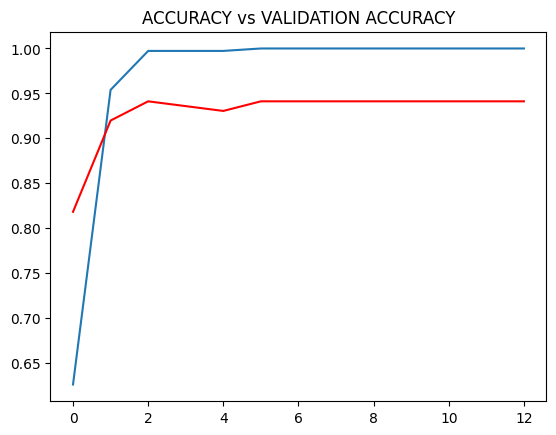

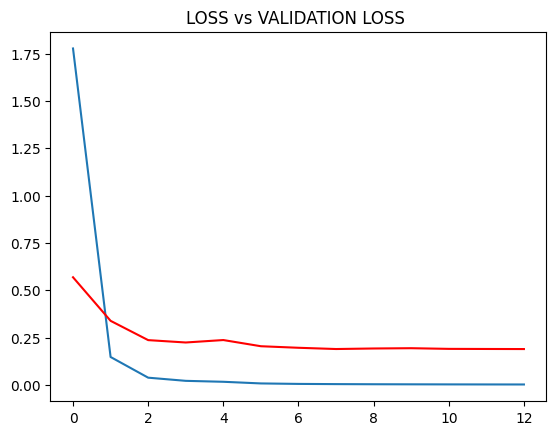

In [13]:
#GRAPHICAL INTERPRETATION
h2 = history_2.history
h2.keys()


import matplotlib.pyplot as plt
plt.plot(h2['accuracy'])
plt.plot(h2['val_accuracy'],c='red')
plt.title("ACCURACY vs VALIDATION ACCURACY")
plt.show()


import matplotlib.pyplot as plt
plt.plot(h2['loss'])
plt.plot(h2['val_loss'],c='red')
plt.title("LOSS vs VALIDATION LOSS ")
plt.show()

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


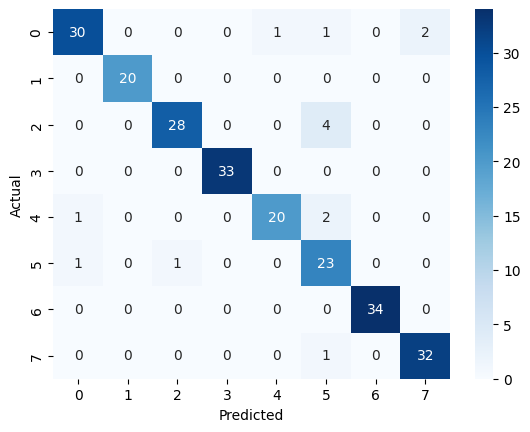

8/8 [==============================] - 2s 278ms/step
Accuracy: 0.9402
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        34
           1       1.00      1.00      1.00        20
           2       0.97      0.88      0.92        32
           3       1.00      1.00      1.00        33
           4       0.95      0.87      0.91        23
           5       0.74      0.92      0.82        25
           6       1.00      1.00      1.00        34
           7       0.94      0.97      0.96        33

    accuracy                           0.94       234
   macro avg       0.94      0.94      0.94       234
weighted avg       0.95      0.94      0.94       234



In [14]:
from tensorflow.keras.models import load_model
model_VGG16 = load_model(r"bestmodel_2.h5")


real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img]))  # Add an extra dimension for batching

        predictions = model_VGG16.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(real_label, predicted_class)
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

from sklearn.metrics import classification_report, accuracy_score


# Assuming you have predictions from your model on X_test
y_pred = model_VGG16.predict(X_test)

# Decode one-hot encoded labels back to their original form if needed
y_pred_decoded = np.argmax(y_pred, axis=1)
y_test_decoded = np.argmax(y_test_one_hot, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Accuracy: {accuracy:.4f}")

# Compute precision, recall, and F1-score
report = classification_report(y_test_decoded, y_pred_decoded)
print("Classification Report:")
print(report)


# ***MOdel-VGG19***

In [15]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load VGG19 pre-trained on ImageNet data
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the VGG19 base model weights

num_classes = 8  # Change this according to your task

# Create a custom top classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Construct the final model
model_3 = Model(inputs=base_model.input, outputs=predictions)
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50
BATCH_SIZE = 32


#EARLY STOPPING & MODEL CHECKPOINTS
from keras.callbacks import ModelCheckpoint,EarlyStopping

#EARLY STOPPING
es = EarlyStopping(monitor = "val_accuracy",min_delta = 0.01,patience = 10,verbose = 1,mode = 'auto')

#MODEL CHECKPOINTS
mc = ModelCheckpoint(monitor = "val_accuracy",filepath =r"bestmodel_3.h5",verbose = 1,save_best_only = True,mode = 'auto')

cd_3 = [es,mc]


history_3 = model_3.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=BATCH_SIZE,callbacks=cd_3)

Epoch 1/50
23/24 [===========================>..] - ETA: 0s - loss: 1.4339 - accuracy: 0.6427
Epoch 1: val_accuracy improved from -inf to 0.84492, saving model to bestmodel_3.h5
24/24 [==============================] - 4s 121ms/step - loss: 1.4300 - accuracy: 0.6436 - val_loss: 0.3915 - val_accuracy: 0.8449
Epoch 2/50
23/24 [===========================>..] - ETA: 0s - loss: 0.1215 - accuracy: 0.9606
Epoch 2: val_accuracy improved from 0.84492 to 0.89305, saving model to bestmodel_3.h5
24/24 [==============================] - 3s 106ms/step - loss: 0.1212 - accuracy: 0.9607 - val_loss: 0.2843 - val_accuracy: 0.8930
Epoch 3/50
23/24 [===========================>..] - ETA: 0s - loss: 0.0404 - accuracy: 0.9905
Epoch 3: val_accuracy improved from 0.89305 to 0.91444, saving model to bestmodel_3.h5
24/24 [==============================] - 3s 108ms/step - loss: 0.0403 - accuracy: 0.9905 - val_loss: 0.2278 - val_accuracy: 0.9144
Epoch 4/50
23/24 [===========================>..] - ETA: 0s - loss:

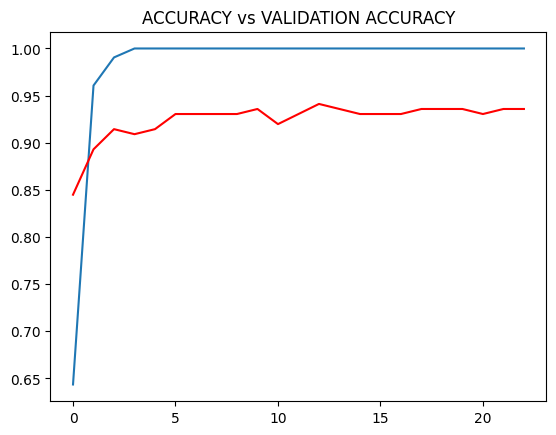

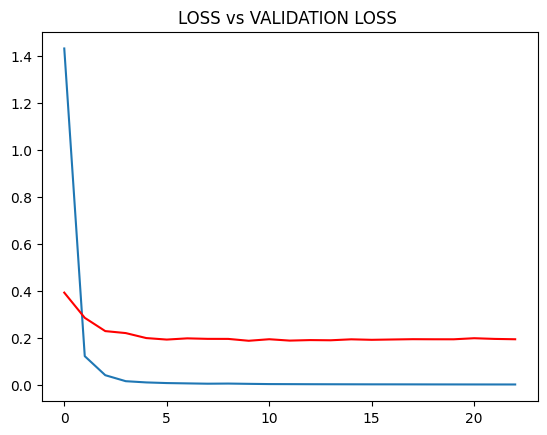

In [16]:
#GRAPHICAL INTERPRETATION
h3 = history_3.history
h3.keys()


import matplotlib.pyplot as plt
plt.plot(h3['accuracy'])
plt.plot(h3['val_accuracy'],c='red')
plt.title("ACCURACY vs VALIDATION ACCURACY")
plt.show()

import matplotlib.pyplot as plt
plt.plot(h3['loss'])
plt.plot(h3['val_loss'],c='red')
plt.title("LOSS vs VALIDATION LOSS ")
plt.show()

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


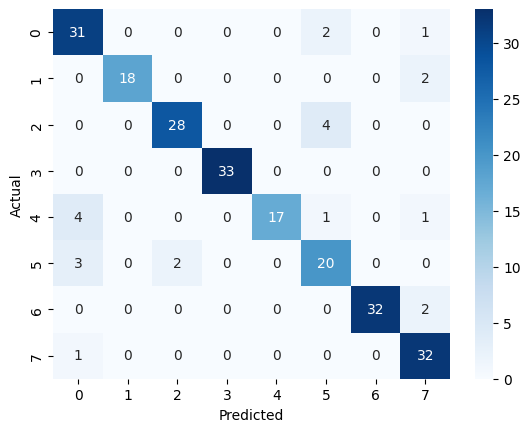

8/8 [==============================] - 1s 118ms/step
Accuracy: 0.9017
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85        34
           1       1.00      0.90      0.95        20
           2       0.93      0.88      0.90        32
           3       1.00      1.00      1.00        33
           4       1.00      0.74      0.85        23
           5       0.74      0.80      0.77        25
           6       1.00      0.94      0.97        34
           7       0.84      0.97      0.90        33

    accuracy                           0.90       234
   macro avg       0.91      0.89      0.90       234
weighted avg       0.91      0.90      0.90       234



In [17]:
from tensorflow.keras.models import load_model
model_VGG19 = load_model(r"bestmodel_3.h5")


real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img]))  # Add an extra dimension for batching

        predictions = model_VGG19.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(real_label, predicted_class)
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

from sklearn.metrics import classification_report, accuracy_score


# Assuming you have predictions from your model on X_test
y_pred = model_VGG19.predict(X_test)

# Decode one-hot encoded labels back to their original form if needed
y_pred_decoded = np.argmax(y_pred, axis=1)
y_test_decoded = np.argmax(y_test_one_hot, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Accuracy: {accuracy:.4f}")

# Compute precision, recall, and F1-score
report = classification_report(y_test_decoded, y_pred_decoded)
print("Classification Report:")
print(report)


# **Custom**

In [18]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.models import Sequential
import numpy as np
# CNN Model
model_c = Sequential()
model_c.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model_c.add(Conv2D(filters=36, kernel_size=(3, 3), activation='relu'))
model_c.add(MaxPool2D(pool_size=(2, 2)))
model_c.add(Dropout(rate=0.3))
model_c.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_c.add(MaxPool2D(pool_size=(2, 2)))
model_c.add(Dropout(rate=0.2))
model_c.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model_c.add(MaxPool2D(pool_size=(2, 2)))
model_c.add(Dropout(rate=0.3))
model_c.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model_c.add(MaxPool2D(pool_size=(2, 2)))
model_c.add(Dropout(rate=0.2))
model_c.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model_c.add(MaxPool2D(pool_size=(2, 2)))
model_c.add(Dropout(rate=0.2))



model_c.add(Flatten())
model_c.add(Dense(units=64, activation='relu'))
model_c.add(Dropout(rate=0.3))
model_c.add(Dense(units=8, activation='softmax'))

model_c.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#EARLY STOPPING & MODEL CHECKPOINTS
from keras.callbacks import ModelCheckpoint,EarlyStopping

#EARLY STOPPING
es = EarlyStopping(monitor = "val_accuracy",min_delta = 0.01,patience = 30,verbose = 1,mode = 'auto')

#MODEL CHECKPOINTS
mc = ModelCheckpoint(monitor = "val_accuracy",filepath =r"bestmodel_custom.h5",verbose = 1,save_best_only = True,mode = 'auto')

cd_c = [es,mc]


history_c = model_c.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = 100, batch_size=32,callbacks=cd_c)

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 11.0170 - accuracy: 0.1504
Epoch 1: val_accuracy improved from -inf to 0.13904, saving model to bestmodel_custom.h5
24/24 [==============================] - 5s 105ms/step - loss: 11.0170 - accuracy: 0.1504 - val_loss: 2.0691 - val_accuracy: 0.1390
Epoch 2/100
23/24 [===========================>..] - ETA: 0s - loss: 2.0767 - accuracy: 0.1345
Epoch 2: val_accuracy improved from 0.13904 to 0.14439, saving model to bestmodel_custom.h5
24/24 [==============================] - 2s 65ms/step - loss: 2.0766 - accuracy: 0.1341 - val_loss: 2.0732 - val_accuracy: 0.1444
Epoch 3/100
23/24 [===========================>..] - ETA: 0s - loss: 2.0558 - accuracy: 0.1630
Epoch 3: val_accuracy improved from 0.14439 to 0.22995, saving model to bestmodel_custom.h5
24/24 [==============================] - 2s 67ms/step - loss: 2.0557 - accuracy: 0.1626 - val_loss: 2.0598 - val_accuracy: 0.2299
Epoch 4/100
23/24 [===========================>..

24/24 [==============================] - 2s 68ms/step - loss: 0.8114 - accuracy: 0.7100 - val_loss: 0.9956 - val_accuracy: 0.6471
Epoch 29/100
23/24 [===========================>..] - ETA: 0s - loss: 0.7159 - accuracy: 0.7405
Epoch 29: val_accuracy improved from 0.64706 to 0.66310, saving model to bestmodel_custom.h5
24/24 [==============================] - 2s 71ms/step - loss: 0.7167 - accuracy: 0.7398 - val_loss: 0.9738 - val_accuracy: 0.6631
Epoch 30/100
23/24 [===========================>..] - ETA: 0s - loss: 0.6836 - accuracy: 0.7283
Epoch 30: val_accuracy did not improve from 0.66310
24/24 [==============================] - 2s 66ms/step - loss: 0.6820 - accuracy: 0.7290 - val_loss: 1.0206 - val_accuracy: 0.6578
Epoch 31/100
23/24 [===========================>..] - ETA: 0s - loss: 0.6016 - accuracy: 0.7649
Epoch 31: val_accuracy did not improve from 0.66310
24/24 [==============================] - 2s 67ms/step - loss: 0.6031 - accuracy: 0.7642 - val_loss: 1.0580 - val_accuracy: 0.

23/24 [===========================>..] - ETA: 0s - loss: 0.2896 - accuracy: 0.8954
Epoch 57: val_accuracy did not improve from 0.72727
24/24 [==============================] - 2s 65ms/step - loss: 0.2901 - accuracy: 0.8957 - val_loss: 1.1912 - val_accuracy: 0.6898
Epoch 58/100
23/24 [===========================>..] - ETA: 0s - loss: 0.3387 - accuracy: 0.8872
Epoch 58: val_accuracy did not improve from 0.72727
24/24 [==============================] - 2s 64ms/step - loss: 0.3380 - accuracy: 0.8875 - val_loss: 1.2763 - val_accuracy: 0.6898
Epoch 59/100
23/24 [===========================>..] - ETA: 0s - loss: 0.2793 - accuracy: 0.8954
Epoch 59: val_accuracy did not improve from 0.72727
24/24 [==============================] - 2s 64ms/step - loss: 0.2785 - accuracy: 0.8957 - val_loss: 1.2033 - val_accuracy: 0.7166
Epoch 60/100
23/24 [===========================>..] - ETA: 0s - loss: 0.2919 - accuracy: 0.8927
Epoch 60: val_accuracy did not improve from 0.72727
24/24 [========================

23/24 [===========================>..] - ETA: 0s - loss: 0.2786 - accuracy: 0.9090
Epoch 86: val_accuracy did not improve from 0.75936
24/24 [==============================] - 2s 64ms/step - loss: 0.2784 - accuracy: 0.9092 - val_loss: 1.2018 - val_accuracy: 0.7326
Epoch 87/100
23/24 [===========================>..] - ETA: 0s - loss: 0.2734 - accuracy: 0.9022
Epoch 87: val_accuracy did not improve from 0.75936
24/24 [==============================] - 1s 61ms/step - loss: 0.2727 - accuracy: 0.9024 - val_loss: 1.2859 - val_accuracy: 0.7166
Epoch 88/100
23/24 [===========================>..] - ETA: 0s - loss: 0.1767 - accuracy: 0.9348
Epoch 88: val_accuracy did not improve from 0.75936
24/24 [==============================] - 1s 62ms/step - loss: 0.1768 - accuracy: 0.9350 - val_loss: 1.2386 - val_accuracy: 0.7326
Epoch 89/100
23/24 [===========================>..] - ETA: 0s - loss: 0.1638 - accuracy: 0.9280
Epoch 89: val_accuracy did not improve from 0.75936
24/24 [========================

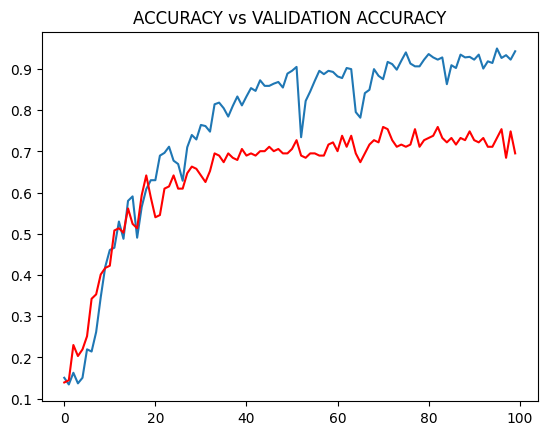

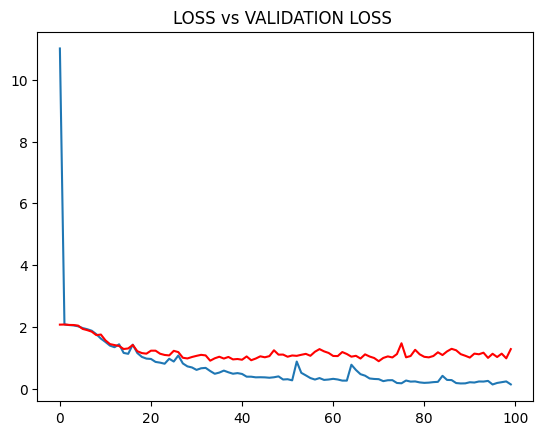

In [19]:
#GRAPHICAL INTERPRETATION
hc = history_c.history
hc.keys()

import matplotlib.pyplot as plt
plt.plot(hc['accuracy'])
plt.plot(hc['val_accuracy'],c='red')
plt.title("ACCURACY vs VALIDATION ACCURACY")
plt.show()



import matplotlib.pyplot as plt
plt.plot(hc['loss'])
plt.plot(hc['val_loss'],c='red')
plt.title("LOSS vs VALIDATION LOSS ")
plt.show()

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


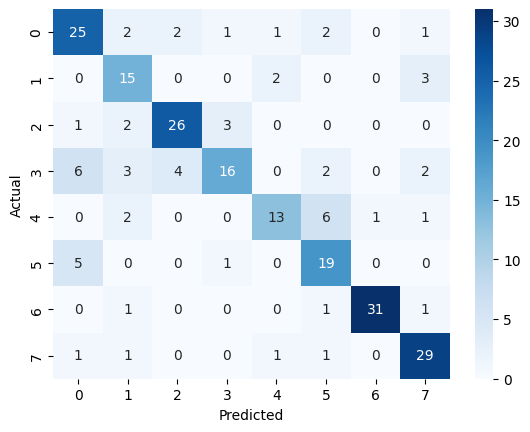

8/8 [==============================] - 1s 68ms/step
Accuracy: 0.7436
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.74      0.69        34
           1       0.58      0.75      0.65        20
           2       0.81      0.81      0.81        32
           3       0.76      0.48      0.59        33
           4       0.76      0.57      0.65        23
           5       0.61      0.76      0.68        25
           6       0.97      0.91      0.94        34
           7       0.78      0.88      0.83        33

    accuracy                           0.74       234
   macro avg       0.74      0.74      0.73       234
weighted avg       0.76      0.74      0.74       234



In [20]:
from tensorflow.keras.models import load_model
model_de = load_model(r"bestmodel_custom.h5")


real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img]))  # Add an extra dimension for batching

        predictions = model_de.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(real_label, predicted_class)
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

from sklearn.metrics import classification_report, accuracy_score


# Assuming you have predictions from your model on X_test
y_pred = model_de.predict(X_test)

# Decode one-hot encoded labels back to their original form if needed
y_pred_decoded = np.argmax(y_pred, axis=1)
y_test_decoded = np.argmax(y_test_one_hot, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Accuracy: {accuracy:.4f}")

# Compute precision, recall, and F1-score
report = classification_report(y_test_decoded, y_pred_decoded)
print("Classification Report:")
print(report)


In [21]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
import numpy as np

# ***Model Loading For Ensemble***

In [22]:
model_e5 = load_model(r"bestmodel_5.h5")
model_e5 = Model(inputs=model_e5.inputs,
                outputs=model_e5.outputs,
                name='name_of_model_e5')


In [23]:
model_e2 = load_model(r"bestmodel_2.h5")
model_e2 = Model(inputs=model_e2.inputs,
                outputs=model_e2.outputs,
                name='name_of_model_e2')


In [24]:
model_e3 = load_model(r"bestmodel_3.h5")
model_e3 = Model(inputs=model_e3.inputs,
                outputs=model_e3.outputs,
                name='name_of_model_e3')


In [25]:
model_ee = load_model(r"bestmodel_custom.h5")
model_ee = Model(inputs=model_ee.inputs,
             outputs=model_ee.outputs,
              name='name_of_model_ee')

# ***Ensemble Model-1***

In [26]:
models_1 = [model_e5,model_e2, model_ee]

weights_1 = [0.9,0.7, 1.2]

#w = np.array([0.7, 0.9])
model_input_1 = Input(shape=(224, 224, 3))
model_outputs_1 = [model(model_input_1) for model in models_1]

#ensemble = VotingClassifier(estimators=models, weights=w, voting='soft')
ensemble_output_1 = Average()(model_outputs_1)
ensemble_model_1 = Model(inputs=model_input_1, outputs=ensemble_output_1, name='ensemble_model_1')

ensemble_model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
#EARLY STOPPING & MODEL CHECKPOINTS

from keras.callbacks import ModelCheckpoint,EarlyStopping

#EARLY STOPPING
es = EarlyStopping(monitor = "val_accuracy",min_delta = 0.01,patience = 10,verbose = 1,mode = 'auto')

#MODEL CHECKPOINTS
mc = ModelCheckpoint(monitor = "val_accuracy",filepath =r"C:bestmodel_ensemble1.h5",verbose = 1,save_best_only = True, mode = 'auto')

cd_n = [es,mc]



history_ensemble_1= ensemble_model_1.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = 50, batch_size=8,callbacks=cd_n)

Epoch 1/50
92/93 [============================>.] - ETA: 0s - loss: 0.2126 - accuracy: 0.9660
Epoch 1: val_accuracy improved from -inf to 0.83422, saving model to C:bestmodel_ensemble1.h5
93/93 [==============================] - 18s 111ms/step - loss: 0.2120 - accuracy: 0.9661 - val_loss: 0.7985 - val_accuracy: 0.8342
Epoch 2/50
92/93 [============================>.] - ETA: 0s - loss: 0.6810 - accuracy: 0.8003
Epoch 2: val_accuracy did not improve from 0.83422
93/93 [==============================] - 7s 75ms/step - loss: 0.6806 - accuracy: 0.8008 - val_loss: 0.9200 - val_accuracy: 0.6738
Epoch 3/50
92/93 [============================>.] - ETA: 0s - loss: 0.7334 - accuracy: 0.8247
Epoch 3: val_accuracy did not improve from 0.83422
93/93 [==============================] - 7s 75ms/step - loss: 0.7335 - accuracy: 0.8238 - val_loss: 0.9484 - val_accuracy: 0.8182
Epoch 4/50
92/93 [============================>.] - ETA: 0s - loss: 0.4572 - accuracy: 0.9402
Epoch 4: val_accuracy improved from 

93/93 [==============================] - 7s 76ms/step - loss: 0.3515 - accuracy: 0.9959 - val_loss: 0.6384 - val_accuracy: 0.9305
Epoch 29: early stopping


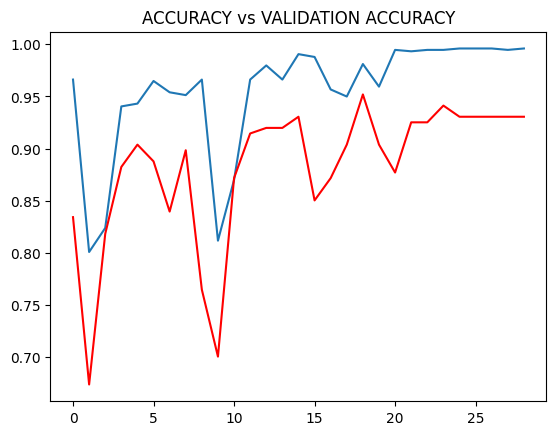

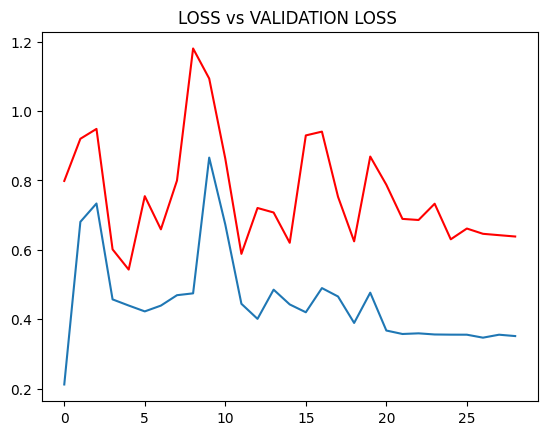

In [28]:
#GRAPHICAL INTERPRETATION
he1 = history_ensemble_1.history
he1.keys()

import matplotlib.pyplot as plt
plt.plot(he1['accuracy'])
plt.plot(he1['val_accuracy'],c='red')
plt.title("ACCURACY vs VALIDATION ACCURACY")
plt.show()



import matplotlib.pyplot as plt
plt.plot(he1['loss'])
plt.plot(he1['val_loss'],c='red')
plt.title("LOSS vs VALIDATION LOSS ")
plt.show()

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


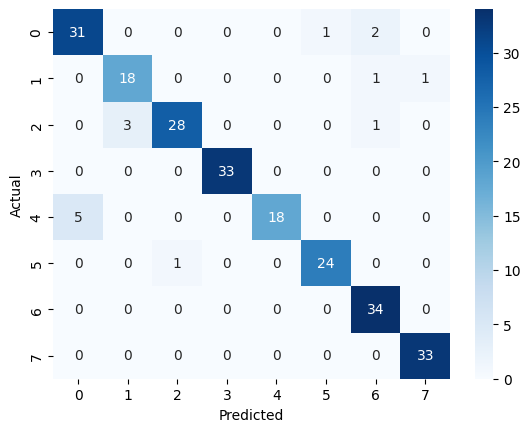

8/8 [==============================] - 1s 166ms/step
Accuracy: 0.9402
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        34
           1       0.86      0.95      0.90        20
           2       0.97      0.88      0.92        32
           3       1.00      1.00      1.00        33
           4       1.00      0.78      0.88        23
           5       0.96      0.96      0.96        25
           6       0.89      1.00      0.94        34
           7       1.00      1.00      1.00        33

    accuracy                           0.94       234
   macro avg       0.94      0.93      0.94       234
weighted avg       0.94      0.94      0.94       234



In [29]:
from tensorflow.keras.models import load_model
model_ensmble1 = load_model(r"bestmodel_ensemble1.h5")

real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img]))  # Add an extra dimension for batching

        predictions = model_ensmble1.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(real_label, predicted_class)
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

from sklearn.metrics import classification_report, accuracy_score


# Assuming you have predictions from your model on X_test
y_pred = model_ensmble1.predict(X_test)

# Decode one-hot encoded labels back to their original form if needed
y_pred_decoded = np.argmax(y_pred, axis=1)
y_test_decoded = np.argmax(y_test_one_hot, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Accuracy: {accuracy:.4f}")

# Compute precision, recall, and F1-score
report = classification_report(y_test_decoded, y_pred_decoded)
print("Classification Report:")
print(report)


# ***Ensemble Model-2***

In [30]:
models_2 = [model_e2,model_e3, model_ee]

weights_2 = [0.9,0.7, 1.2]

#w = np.array([0.7, 0.9])
model_input_2 = Input(shape=(224, 224, 3))
model_outputs_2 = [model(model_input_2) for model in models_2]

#ensemble = VotingClassifier(estimators=models, weights=w, voting='soft')
ensemble_output_2 = Average()(model_outputs_2)
ensemble_model_2 = Model(inputs=model_input_2, outputs=ensemble_output_2, name='ensemble_model_2')

ensemble_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
#EARLY STOPPING & MODEL CHECKPOINTS

from keras.callbacks import ModelCheckpoint,EarlyStopping

#EARLY STOPPING
es_2 = EarlyStopping(monitor = "val_accuracy",min_delta = 0.01,patience = 10,verbose = 1,mode = 'auto')

#MODEL CHECKPOINTS
mc_2 = ModelCheckpoint(monitor = "val_accuracy",filepath =r"bestmodel_ensemble2.h5",verbose = 1,save_best_only = True, mode = 'auto')

cd_n2 = [es_2,mc_2]



history_ensemble_2= ensemble_model_2.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = 50, batch_size=8,callbacks=cd_n2)

Epoch 1/50
92/93 [============================>.] - ETA: 0s - loss: 0.4731 - accuracy: 0.9823
Epoch 1: val_accuracy improved from -inf to 0.91444, saving model to bestmodel_ensemble2.h5
93/93 [==============================] - 10s 88ms/step - loss: 0.4729 - accuracy: 0.9824 - val_loss: 0.6811 - val_accuracy: 0.9144
Epoch 2/50
92/93 [============================>.] - ETA: 0s - loss: 0.5381 - accuracy: 0.9185
Epoch 2: val_accuracy did not improve from 0.91444
93/93 [==============================] - 7s 79ms/step - loss: 0.5377 - accuracy: 0.9187 - val_loss: 1.0898 - val_accuracy: 0.8128
Epoch 3/50
92/93 [============================>.] - ETA: 0s - loss: 0.4735 - accuracy: 0.9090
Epoch 3: val_accuracy did not improve from 0.91444
93/93 [==============================] - 7s 80ms/step - loss: 0.4733 - accuracy: 0.9092 - val_loss: 0.7116 - val_accuracy: 0.8235
Epoch 4/50
92/93 [============================>.] - ETA: 0s - loss: 0.8980 - accuracy: 0.7636
Epoch 4: val_accuracy did not improve f